<a href="https://colab.research.google.com/github/mtcarilli/bursty-deg-cme/blob/main/deg_cme_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import numpy as np

import scipy
from scipy.integrate import odeint
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn

import matplotlib.pyplot as plt

In [72]:
# get grid of u to solve PGF on before IFFT -- from Gennady, https://github.com/mtcarilli/ATAC_RNA/blob/main/pss_evaluation.py#L40
def get_g(mx):
    u = []
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    g = [g_.flatten() for g_ in g]
    return g

In [73]:
# define the ODEs

def coupled_PGF(s,G,u,k,lambda1,lambda2,r1,r2):
  '''Sets up the coupled PGFs dG1/ds and dG2/ds for a model of constitutive transcription with two states of degradation.

  Variables
  -------------
  G: list of [G1,G2]
  s: integral variable
  u: PGF variable, change of variables u = g -1
  k: rate of transcription
  lambda1: rate of degradation of G1
  lambda2: rate of degradation of G2
  r1: rate of switching between state 2 and 1
  r2: rate of switching between state 1 and 2
  '''
  G1,G2 = G
  dG1ds = k*u*np.exp(-lambda1*s)*G1 + r1*G2 -  r2*G1
  dG2ds = k*u*np.exp(-lambda2*s)*G2 + r2*G1 -  r1*G2
  return [-dG1ds,-dG2ds]



k = 10    # rate of production
lambda1 = 10   # rate of degradation in state 1
lambda2 = 1   # rate of degradation in state 2
r1 = 4     # rate of switching from state 2 to 1
r2 = 1    # rate of switching from state 1 to 2


H = np.array([[-r2,r2],[r1,-r1]])   # state switching matrix
Hfin = scipy.linalg.null_space(H.T)  # set initial condition using null space of transition matrix
Hfin /= Hfin.sum()
initcond = Hfin.squeeze().astype(np.complex128)
# initcond = np.array([.5,.5],dtype=np.complex128)





In [74]:

t = np.linspace(0, 10, 10000)
lim = 100
mx = [int(lim)]
g = get_g(mx)

pgf = np.zeros((lim,2),dtype=np.complex128)

for i,u in enumerate(g[0]):

  intfun = lambda t,y: coupled_PGF(t,y,u,k,lambda1,lambda2,r1,r2)
  res = scipy.integrate.solve_ivp(intfun,[10,0],initcond)
  pgf[i,:] = res.y[:,-1]


PSS = np.zeros(mx + [2])

PSS[:,0] = np.real( ifft2(np.reshape(pgf[:,0], (-1,lim) ) ).flatten() )
PSS[:,1] = np.real( ifft2(np.reshape(pgf[:,1], (-1,lim) ) ).flatten() )

In [75]:
# PSS = np.abs(PSS)
# PSS = PSS/PSS.sum()

In [76]:
PSS.sum()

np.float64(0.9999999999999999)

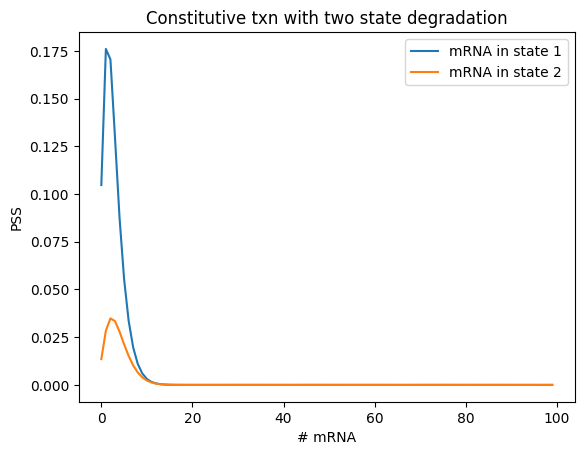

In [82]:
plt.plot(PSS[:,0],label='mRNA in state 1')
plt.plot(PSS[:,1],label='mRNA in state 2')
plt.title('Constitutive txn with two state degradation')
plt.legend()
plt.xlabel('# mRNA')
plt.ylabel('PSS');